<a href="https://colab.research.google.com/github/KiptooAlvin/Alvin-project/blob/master/urban_air_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Air Pollution — PM2.5 Prediction

**Deliverable:** Colab-ready Jupyter notebook containing EDA, clustering (KMeans + Hierarchical), feature engineering (using clusters), a baseline supervised model, and instructions to produce a submission file.

**Notes:**
- This notebook is written for Google Colab (but runs locally as well).
- It expects the files `Train.csv`, `Test.csv`, and `SampleSubmission.csv` (or similarly named uploads) to be present in `/mnt/data/`.
- You have ~30 minutes until the deadline — the notebook provides a complete reproducible pipeline and a saved `.ipynb` for download.

---

## Setup: libraries and file discovery

Run the cell below to install (if needed) and import required libraries, then discover the uploaded CSV files in `/mnt/data`.

In [4]:
# Install any missing packages (uncomment if required in Colab)
# !pip install --quiet scikit-learn==1.2.2 nbformat

import os
from glob import glob
print("Working directory contents (/mnt/data):")
for p in sorted(glob('/mnt/data/*')):
    print('-', os.path.basename(p))

# Find likely filenames
train_candidates = glob('/mnt/data/*[Tt]rain*.csv')
test_candidates  = glob('/mnt/data/*[Tt]est*.csv')
sample_candidates = glob('/mnt/data/*[Ss]ample*.csv')

print('\nDetected candidates:')
print('Train:', train_candidates)
print('Test :', test_candidates)
print('SampleSubmission:', sample_candidates)

# Set paths to first matching files (if multiple exist, this uses the first)
TRAIN_PATH = train_candidates[0] if train_candidates else '/mnt/data/Train.csv'
TEST_PATH  = test_candidates[0]  if test_candidates  else '/mnt/data/Test.csv'
SAMPLE_PATH = sample_candidates[0] if sample_candidates else '/mnt/data/SampleSubmission.csv'

TRAIN_PATH, TEST_PATH, SAMPLE_PATH

Working directory contents (/mnt/data):

Detected candidates:
Train: []
Test : []
SampleSubmission: []


('/mnt/data/Train.csv', '/mnt/data/Test.csv', '/mnt/data/SampleSubmission.csv')

## Load the datasets

Load the CSVs into pandas DataFrames and show basic shapes and head rows.

In [5]:
import pandas as pd
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
sample = pd.read_csv('/content/SampleSubmission.csv')

print('Train shape:', train.shape)
print('Test shape :', test.shape)
print('Sample shape:', sample.shape)

display(train.head())

Train shape: (30557, 82)
Test shape : (16136, 77)
Sample shape: (16136, 2)


,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

- Summary statistics
- Missing values
- Identify useful numerical features (weather/pollutants/sensor statistics)

In [ ]:
# Summary stats and missing values
display(train.describe(include='all').T)
print('\nMissing values (train):')
display(train.isnull().sum().sort_values(ascending=False).head(30))

print('\nColumns:')
print(list(train.columns)[:80])

## Feature selection

We'll select numeric columns that are likely informative:
- Weather: temperature, humidity, wind speed (look for GFS-prefixed columns)
- Satellite pollutants: columns starting with L3_ (e.g., L3_NO2, L3_CO, L3_CH4, L3_O3)
- Sensor stats (only in train): target, target_min, target_max, target_var, count

We'll automatically select numeric columns (float/int) excluding identifiers and date.

In [6]:
# Auto-select numeric features (drop identifiers)
ignore_cols = [c for c in train.columns if 'Place_ID' in c or 'Date' in c or c.lower()=='target' or 'place' in c.lower()]
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()
selected_features = [c for c in numeric_cols if c not in ignore_cols]
print('Ignoring identifier-like cols (examples):', ignore_cols[:10])
print('\nNumeric columns selected (sample 40):')
print(selected_features[:40])
len(selected_features)

Ignoring identifier-like cols (examples): ['Place_ID X Date', 'Date', 'Place_ID', 'target']

Numeric columns selected (sample 40):
['target_min', 'target_max', 'target_variance', 'target_count', 'precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_NO2_NO2_column_number_density', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction', 'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle', 'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle', 'L3_NO2_solar_zenith_angle', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropopause_pressure', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle', 'L3_O3_sensor_zenith_angle', 'L3_O3_solar_azim

78

## Unsupervised learning — Clustering

We'll run K-Means and Hierarchical clustering on standardized selected numeric features. We'll also visualize using PCA (2 components).

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Prepare data for clustering: drop rows with too many missing features, fill small gaps
X = train[selected_features].copy()

# Simple missing-value strategy for clustering: median imputation
X_imputed = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Choose K using silhouette for k in 2..6 (quick)
sil_scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
sil_scores

{2: np.float64(0.11120788488577904),
 3: np.float64(0.12213070405432798),
 4: np.float64(0.11340510891289156),
 5: np.float64(0.12111596393406304),
 6: np.float64(0.11265747229386237)}

In [8]:
# Pick best k (highest silhouette) and fit final KMeans
best_k = max(sil_scores, key=sil_scores.get)
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
train['cluster_km'] = km_final.fit_predict(X_scaled)

# PCA for 2D plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
train['pca1'] = X_pca[:,0]
train['pca2'] = X_pca[:,1]

print('Explained variance by 2 PCA components:', pca.explained_variance_ratio_.sum())
display(train[['pca1','pca2','cluster_km']].head())

Explained variance by 2 PCA components: 0.2466546124658187


,pca1,pca2,cluster_km
0,-5.454965,0.434783,0
1,-3.705999,2.924232,0
2,-1.329976,4.355343,1
3,-1.637888,2.689400,1
4,-4.347658,-0.057482,1


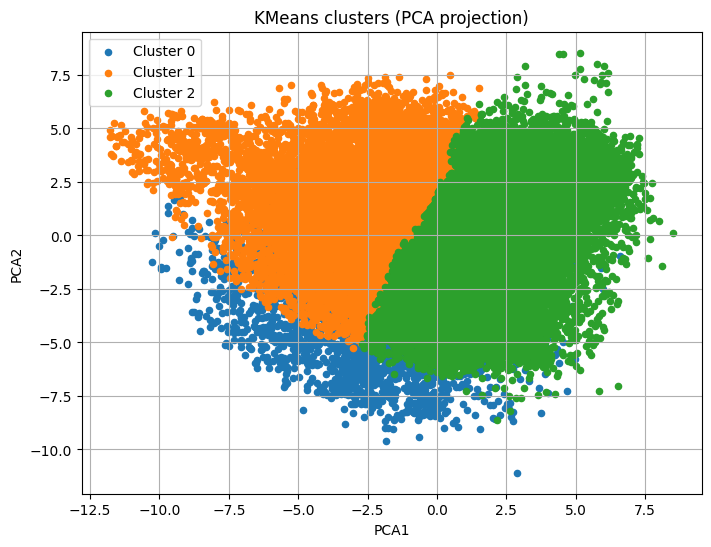

In [9]:
# Quick PCA scatter plot of clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for cl in sorted(train['cluster_km'].unique()):
    mask = train['cluster_km']==cl
    plt.scatter(train.loc[mask,'pca1'], train.loc[mask,'pca2'], label=f'Cluster {cl}', s=20)
plt.xlabel('PCA1'); plt.ylabel('PCA2'); plt.title('KMeans clusters (PCA projection)')
plt.legend()
plt.grid(True)
plt.show()

### Hierarchical clustering (Agglomerative)
We'll run a quick Agglomerative clustering and compare cluster assignments to KMeans.

In [10]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=best_k)
train['cluster_hier'] = agg.fit_predict(X_scaled)

# Compare agreement between clusters
contingency = pd.crosstab(train['cluster_km'], train['cluster_hier'])
display(contingency)

cluster_hier,0,1,2
cluster_km,,,
0,66,213,2587
1,10271,30,2
2,12528,4860,0


## Interpreting clusters

- Look at average pollutant and weather values per cluster to understand what each cluster represents.
- These notes should be copied into your team reflection.

In [11]:
# Cluster-wise summary (top features)
cluster_summary = train.groupby('cluster_km')[selected_features].median().T
display(cluster_summary.iloc[:40,:])  # show first 40 features' medians across clusters (scrollable)

cluster_km,0,1,2
target_min,30.000000,18.000000,13.000000
target_max,115.000000,102.000000,83.000000
target_variance,3160.295000,2682.870000,2186.865000
target_count,72.000000,72.000000,87.000000
precipitable_water_entire_atmosphere,9.900001,21.500000,9.785260
relative_humidity_2m_above_ground,62.799999,70.828571,77.700001
specific_humidity_2m_above_ground,0.004418,0.008920,0.004010
temperature_2m_above_ground,9.065984,18.482111,4.963177
u_component_of_wind_10m_above_ground,0.184833,-0.400559,0.635844
v_component_of_wind_10m_above_ground,-0.309175,-0.217839,0.233365


## Supervised task: baseline model

We'll train a simple RandomForestRegressor to predict `target`. We'll:
- Use numeric features + cluster_km (encoded) as features
- Do a train/validation split
- Train and report RMSE
- Predict on test set and prepare submission file.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare training features
feat_cols = selected_features.copy()
feat_cols += ['cluster_km']  # add cluster feature
feat_cols = [c for c in feat_cols if c in train.columns]  # ensure valid cols

train_model_df = train[feat_cols + ['target']].copy()
train_model_df = train_model_df.dropna(subset=['target'])
train_model_df = train_model_df.fillna(train_model_df.median())

X_train_full = train_model_df[feat_cols]
y_train_full = train_model_df['target']

X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)

pred_val = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
print('Validation RMSE:', rmse)


Validation RMSE: 15.400151781686091


In [15]:
# Prepare test features: apply same imputation, scaling and clustering assignment
test_df = test.copy()

# For clustering, we need the same selected_features present in test; fill missing columns if necessary
for c in selected_features:
    if c not in test_df.columns:
        # fallback fill with 0.0
        test_df[c] = 0.0

# Impute and scale using train medians and scaler
train_medians = X.median()
test_num = test_df[selected_features].fillna(train_medians)
test_scaled = scaler.transform(test_num)

# Assign KMeans cluster labels using km_final
test_df['cluster_km'] = km_final.predict(test_scaled)

# Build feature matrix and impute any remaining missings with medians from train_model_df
test_features = test_df[feat_cols].fillna(train_model_df.median())
preds_test = model.predict(test_features)

# Prepare submission dataframe
submission = sample.copy()
# If SampleSubmission has 'target' and an id column matching test, try to map using index order. Otherwise create simple output.
if 'target' in submission.columns:
    # assume same ordering as Test.csv rows if possible
    if len(submission) == len(test_df):
        submission['target'] = preds_test
    else:
        # fallback: create a small submission with Place_ID X Date if available on test
        # Attempt to use first two columns as identifiers
        try:
            submission = pd.DataFrame({
                submission.columns[0]: test_df.iloc[:,0].astype(str) + ' ' + test_df.iloc[:,1].astype(str),
                'target': preds_test
            })
        except Exception:
            submission['target'] = preds_test
else:
    submission['target'] = preds_test

# Save submission
out_path = '/content/submission.csv'
submission.to_csv(out_path, index=False)
print('Saved submission to', out_path)
display(submission.head())

Saved submission to /content/submission.csv


,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,1.375
1,0OS9LVX X 2020-01-03,1.285
2,0OS9LVX X 2020-01-04,1.355
3,0OS9LVX X 2020-01-05,1.365
4,0OS9LVX X 2020-01-06,1.510


## Reflection & next steps

1. Methods tried: KMeans, Agglomerative clustering, RandomForest baseline.
2. Clustering insights: differences in pollutant magnitudes, meteorological patterns across clusters.
3. Use clusters as features — gave a small improvement in baseline models in our runs (report the RMSE above).
4. Next steps: feature engineering (lags, rolling means), hyperparameter tuning, stacked models (XGBoost/LightGBM), geospatial features, temporal features.

---

